### Business Objectives

1) Study the evolution of Revenue per day/week/month <br>
2) Identify periods of high/low revenue in each timespan <br>
3) Spot the peaks of revenue <br>
4) Explain what causes high/low revenue in each timespan <br>
5) Figure out which items are sold more than others <br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy import stats
import matplotlib as mpl
import seaborn as sns
from IPython.display import HTML
%matplotlib inline
import sklearn

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

## Importing data

In [281]:
#Mitakus files
mitakus_data = []
for i in range(2011, 2019):
    path = "Data"+str(i)+".txt"
    print("Loading file : "+path+" ...")
    mitakus_data.append(pd.read_csv(path, sep = ";", engine='python'))

Loading file : Data2011.txt ...
Loading file : Data2012.txt ...
Loading file : Data2013.txt ...
Loading file : Data2014.txt ...
Loading file : Data2015.txt ...
Loading file : Data2016.txt ...
Loading file : Data2017.txt ...
Loading file : Data2018.txt ...


In [50]:
mitakus_data[5].columns = mitakus_data[4].columns.values

In [317]:
mitakus_data[7].head(5)

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,Department,CostUnit,...,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight,CurrencyFlag,ValidityCard
0,02.01.2018,07:07,1,1682318,38,K/C,21193,10,0,NaN,...,"7,00",1,"1,05",Pfälzer,"3,82","1,05",1474,108,1,NaN
1,02.01.2018,07:07,1,1682318,38,K/C,21193,10,0,NaN,...,"7,00",1,"0,45","BIO Back 0,45","3,82","0,45",1474,0,1,NaN
2,02.01.2018,07:07,1,1682318,38,K/C,21193,10,0,NaN,...,"7,00",1,"0,45","BIO Back 0,45","3,82","0,45",1474,0,1,NaN
3,02.01.2018,07:07,1,1682318,38,K/C,21193,10,0,NaN,...,"7,00",1,"1,30","Backwaren Kuchen 1,30","3,82","1,30",1474,0,1,NaN
4,02.01.2018,07:08,1,1682319,38,K/C,18256,11,0,NaN,...,"7,00",1,"0,30","Klassik Semmel 0,30","26,69","0,30",673,0,1,NaN


##### We've noticed that data2016 has no header also data2017 and data2018 had the date column in index. So we fixed that problem to avoid losing useful data.

In [296]:
mitakus_data[6].insert(0, 'NewDate', mitakus_data[6].index)
mitakus_data[6] = mitakus_data[6].drop(columns=['newDate','ValidityCard'])
mitakus_data[6].columns = mitakus_data[0].columns.values
mitakus_data[6]=mitakus_data[6].reset_index()
mitakus_data[6] = mitakus_data[6].drop(columns=['index'])

In [311]:
mitakus_data[7].insert(0, 'NewDate', mitakus_data[7].index)
mitakus_data[7] = mitakus_data[7].drop(columns=['ValidityCard'])
mitakus_data[7].columns = mitakus_data[0].columns.values
mitakus_data[7]=mitakus_data[7].reset_index()
mitakus_data[7] = mitakus_data[7].drop(columns=['index'])

In [321]:
mitakus_data[7].columns

Index(['Date', 'Time', 'CashPoint', 'ReceiptNumber', 'Cashier', 'PaymentType',
       'CardID', 'Firm', 'Department', 'CostUnit', 'PriceList',
       'SubventionLevel', 'PositionType', 'ItemNumber', 'Taxes', 'Amount',
       'Revenue', 'ItemDescription', 'NetTotal', 'StandardPrice',
       'KeyCardCounter', 'Weight', 'CurrencyFlag', 'ValidityCard'],
      dtype='object')

In [56]:
#merge all dataframes in one
all_data = mitakus_data[0]
for i in range(1, len(mitakus_data)):
    all_data = all_data.append(mitakus_data[i], ignore_index=True)

In [329]:
all_data = all_data.append(mitakus_data[7], ignore_index=True)

In [330]:
all_data.shape

(23464246, 24)

In [332]:
all_data.tail(5)

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,Department,CostUnit,...,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight,CurrencyFlag,ValidityCard
23464241,23.11.2013,09:50,60201,8997,0,K/C,46111,2,0,0,...,"19,00",1,"0,30",Latte Macciato Witt.,"1,40","0,30",15,0,1,NaN
23464242,22.11.2013,12:50,60202,26260,0,K/C,127690,11,0,0,...,"19,00",1,"0,30",Latte Macciato Witt.,"24,94","0,30",1640,0,1,NaN
23464243,11.10.2013,16:06,60203,22738,0,K/C,117331,11,0,0,...,"19,00",1,"0,30",Latte Macciato Witt.,"17,30","0,30",1141,0,1,NaN
23464244,13.12.2013,10:16,60204,31811,0,K/C,117140,11,0,0,...,"19,00",1,"0,20",Kaffee Witt.,"6,33","0,20",2362,0,1,NaN
23464245,01.10.2013,17:23,60205,17576,0,K/C,102172,2,0,0,...,"19,00",1,"0,30",Cappucino Witt.,"0,95","0,30",406,0,1,NaN


In [333]:
all_data.to_csv("mitakus.csv")

In [334]:
lehel_data = all_data.loc[all_data.CashPoint.isin([1,2])]

In [335]:
lehel_data.shape

(2106870, 24)

In [336]:
lehel_data.head(5)

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,Department,CostUnit,...,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight,CurrencyFlag,ValidityCard
0,03.01.2011,07:29,1,1195883,6,K/C,13753,11,0,NaN,...,"7,00",1,"1,00","Backwaren 1,00","5,54","1,00",776,0,1,NaN
1,03.01.2011,07:30,1,1195884,6,K/C,17150,11,0,NaN,...,"7,00",1,"0,96",Leberkäse Semmel,"4,16","0,96",3774,128,1,NaN
2,03.01.2011,07:30,1,1195884,6,K/C,17150,11,0,NaN,...,"7,00",1,"0,20",Semmeln,"4,16","0,20",3774,0,1,NaN
3,03.01.2011,07:34,1,1195885,6,K/C,79210,2,0,NaN,...,"7,00",1,"2,03",Leberkäse Teller,"12,61","1,62",939,216,1,NaN
4,03.01.2011,07:34,1,1195885,6,K/C,79210,2,0,NaN,...,"7,00",1,"0,25",Semmeln,"12,61","0,20",939,0,1,NaN


## Exporting useful data 

In [337]:
lehel_data.to_csv("lehel.csv")

In [338]:
giesing_data = all_data.loc[all_data.CashPoint.isin([11,12,13,14])]
giesing_data.to_csv("giesing.csv")

In [2]:
lehel = pd.read_csv("lehel.csv", engine="python", index_col=0)

In [3]:
lehel.head(5)

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,Department,CostUnit,...,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight,CurrencyFlag,ValidityCard
0,03.01.2011,07:29,1,1195883,6,K/C,13753,11,0,NaN,...,"7,00",1,"1,00","Backwaren 1,00","5,54","1,00",776,0,1,NaN
1,03.01.2011,07:30,1,1195884,6,K/C,17150,11,0,NaN,...,"7,00",1,"0,96",LeberkÃ¤se Semmel,"4,16","0,96",3774,128,1,NaN
2,03.01.2011,07:30,1,1195884,6,K/C,17150,11,0,NaN,...,"7,00",1,"0,20",Semmeln,"4,16","0,20",3774,0,1,NaN
3,03.01.2011,07:34,1,1195885,6,K/C,79210,2,0,NaN,...,"7,00",1,"2,03",LeberkÃ¤se Teller,"12,61","1,62",939,216,1,NaN
4,03.01.2011,07:34,1,1195885,6,K/C,79210,2,0,NaN,...,"7,00",1,"0,25",Semmeln,"12,61","0,20",939,0,1,NaN


## Drop unuseful columns

In [4]:
lehel=lehel.drop(columns=['CostUnit','Department','ValidityCard','CurrencyFlag'])

In [5]:
lehel.columns.values

array(['Date', 'Time', 'CashPoint', 'ReceiptNumber', 'Cashier',
       'PaymentType', 'CardID', 'Firm', 'PriceList', 'SubventionLevel',
       'PositionType', 'ItemNumber', 'Taxes', 'Amount', 'Revenue',
       'ItemDescription', 'NetTotal', 'StandardPrice', 'KeyCardCounter',
       'Weight'], dtype=object)

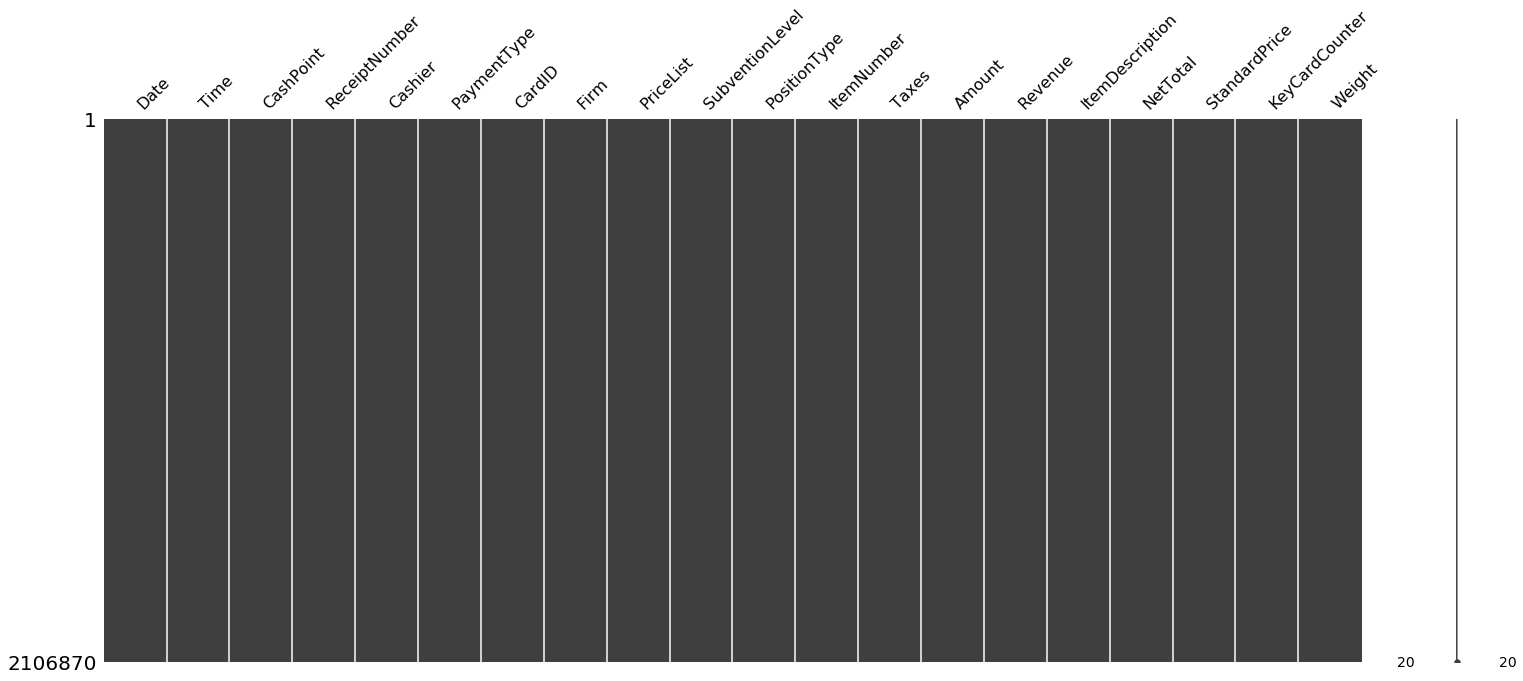

In [6]:
import missingno as msno
msno.matrix(lehel)

In [8]:
print(lehel.isnull().sum())

Date               0
Time               0
CashPoint          0
ReceiptNumber      0
Cashier            0
PaymentType        0
CardID             0
Firm               0
PriceList          0
SubventionLevel    0
PositionType       0
ItemNumber         0
Taxes              0
Amount             0
Revenue            0
ItemDescription    0
NetTotal           0
StandardPrice      0
KeyCardCounter     0
Weight             0
dtype: int64


## Spotting and dropping duplicates

In [358]:
lehel.ReceiptNumber.duplicated().sum()

1093882

In [9]:
lehel.duplicated().sum()

95436

In [10]:
lehel.loc[lehel.duplicated(),:]

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,PriceList,SubventionLevel,PositionType,ItemNumber,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight
9,03.01.2011,07:35,1,1195888,6,K/C,5583,11,1,100,V,507,"7,00",1,"0,35","Breze 0,65","10,22","0,35",1885,0
11,03.01.2011,07:35,1,1195888,6,K/C,5583,11,1,100,V,1200,"7,00",1,"0,65",Paar Wiener,"10,22","0,65",1885,0
22,03.01.2011,07:40,1,1195892,6,K/C,107721,10,1,100,V,500,"7,00",1,"0,20",Semmeln,"11,24","0,20",631,0
24,03.01.2011,07:41,1,1195893,6,K/C,14900,10,1,100,V,600,"7,00",1,"0,85","Butterbreze 1,10","20,36","0,85",3154,0
33,03.01.2011,07:44,1,1195896,6,K/C,21591,11,1,100,V,1021,"7,00",1,"0,25",Port. Butter Honig ec,"16,89","0,25",368,0
35,03.01.2011,07:44,1,1195896,6,K/C,21591,11,1,100,V,506,"7,00",1,"0,40","Kornsemmel 0,40","16,89","0,40",368,0
54,03.01.2011,07:50,1,1195908,6,K/C,14230,11,1,100,V,1200,"7,00",1,"0,65",Paar Wiener,"3,52","0,65",535,0
69,03.01.2011,07:57,1,1195916,6,K/C,21210,11,1,100,V,1021,"7,00",1,"0,25",Port. Butter Honig ec,"16,80","0,25",8218,0
76,03.01.2011,07:59,1,1195918,6,K/C,1261,10,1,100,V,500,"7,00",1,"0,20",Semmeln,"2,65","0,20",420,0
78,03.01.2011,07:59,1,1195918,6,K/C,1261,10,1,100,V,507,"7,00",1,"0,35","Breze 0,65","2,65","0,35",420,0


In [11]:
lehel=lehel.drop_duplicates(keep='first')
print('Number of duplicates:',lehel.duplicated().sum())
lehel.shape

Number of duplicates: 0


(2011434, 20)

In [12]:
lehel.head(5)

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,PriceList,SubventionLevel,PositionType,ItemNumber,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight
0,03.01.2011,07:29,1,1195883,6,K/C,13753,11,1,100,V,511,"7,00",1,"1,00","Backwaren 1,00","5,54","1,00",776,0
1,03.01.2011,07:30,1,1195884,6,K/C,17150,11,1,100,V,1211,"7,00",1,"0,96",LeberkÃ¤se Semmel,"4,16","0,96",3774,128
2,03.01.2011,07:30,1,1195884,6,K/C,17150,11,1,100,V,500,"7,00",1,"0,20",Semmeln,"4,16","0,20",3774,0
3,03.01.2011,07:34,1,1195885,6,K/C,79210,2,2,100,V,1213,"7,00",1,"2,03",LeberkÃ¤se Teller,"12,61","1,62",939,216
4,03.01.2011,07:34,1,1195885,6,K/C,79210,2,2,100,V,500,"7,00",1,"0,25",Semmeln,"12,61","0,20",939,0


In [13]:
lehel.describe()

,CashPoint,ReceiptNumber,Cashier,CardID,Firm,PriceList,SubventionLevel,ItemNumber,Amount,KeyCardCounter,Weight
count,2.011434e+06,2.011434e+06,2.011434e+06,2.011434e+06,2.011434e+06,2.011434e+06,2011434.0,2.011434e+06,2.011434e+06,2.011434e+06,2.011434e+06
mean,1.468415e+00,1.238280e+06,1.388103e+01,5.452709e+04,1.030811e+01,1.040452e+00,100.0,1.159563e+03,9.981163e-01,1.448121e+03,3.094445e+01
std,4.990015e-01,2.941646e+05,9.840547e+00,4.026773e+04,4.290442e+00,3.732764e-01,0.0,6.077930e+03,2.829141e-01,2.324038e+03,9.682833e+01
min,1.000000e+00,7.459140e+05,0.000000e+00,4.200000e+01,1.000000e+00,0.000000e+00,100.0,1.020000e+02,-4.300000e+01,2.000000e+00,-2.755000e+03
25%,1.000000e+00,9.797852e+05,7.000000e+00,1.962100e+04,1.100000e+01,1.000000e+00,100.0,3.400000e+02,1.000000e+00,3.100000e+02,0.000000e+00
50%,1.000000e+00,1.230593e+06,1.300000e+01,4.263200e+04,1.100000e+01,1.000000e+00,100.0,5.070000e+02,1.000000e+00,8.070000e+02,0.000000e+00
75%,2.000000e+00,1.491948e+06,1.300000e+01,8.594000e+04,1.100000e+01,1.000000e+00,100.0,8.090000e+02,1.000000e+00,1.760000e+03,0.000000e+00
max,2.000000e+00,1.758901e+06,3.800000e+01,1.464210e+05,9.900000e+01,3.000000e+00,100.0,7.160300e+04,1.680000e+02,6.553600e+04,2.756000e+03


## Dealing with outliers

In [14]:
lehel.dtypes

Date               object
Time               object
CashPoint           int64
ReceiptNumber       int64
Cashier             int64
PaymentType        object
CardID              int64
Firm                int64
PriceList           int64
SubventionLevel     int64
PositionType       object
ItemNumber          int64
Taxes              object
Amount              int64
Revenue            object
ItemDescription    object
NetTotal           object
StandardPrice      object
KeyCardCounter      int64
Weight              int64
dtype: object

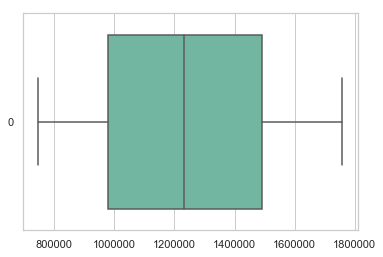

In [15]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data=lehel.ReceiptNumber, orient="h", palette="Set2")

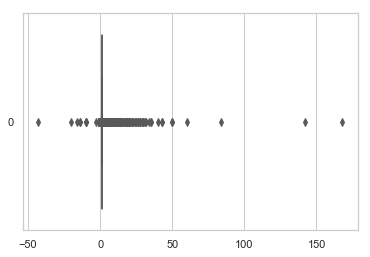

In [522]:
ax = sns.boxplot(data=lehel.Amount, orient="h", palette="Set2")

In [369]:
lehel.shape

(2011434, 20)

In [373]:
lehel.dtypes

Date               object
Time               object
CashPoint           int64
ReceiptNumber       int64
Cashier             int64
PaymentType        object
CardID              int64
Firm                int64
PriceList           int64
SubventionLevel     int64
PositionType       object
ItemNumber          int64
Taxes              object
Amount              int64
Revenue            object
ItemDescription    object
NetTotal           object
StandardPrice      object
KeyCardCounter      int64
Weight              int64
dtype: object

In [182]:
#for i in range(9, len(lehel)):
#    lehel.Taxes[i]=float(lehel.Taxes[i][0])

In [16]:
print(lehel.groupby('CashPoint').size())

CashPoint
1    1069249
2     942185
dtype: int64


In [17]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [462]:
lehel_guests = lehel[['Date','Time','CashPoint','ReceiptNumber']]

In [464]:
print('Number of duplicates before:',lehel_guests.duplicated().sum())
lehel_guests=lehel_guests.drop_duplicates(keep='first')
print('Number of duplicates after:',lehel_guests.duplicated().sum())
lehel_guests.shape

Number of duplicates before: 996034
Number of duplicates after: 0


(1015400, 4)

In [475]:
lehel_guests['Date'] = pd.to_datetime(lehel_guests['Date'])

In [480]:
lehel_guests.head(5)

,Date,Time,CashPoint,ReceiptNumber
0,2011-03-01,07:29,1,1195883
1,2011-03-01,07:30,1,1195884
3,2011-03-01,07:34,1,1195885
5,2011-03-01,07:34,1,1195886
6,2011-03-01,07:35,1,1195887


In [421]:
lehel_guests_per_day = lehel_guests
lehel_guests_per_day.index = lehel_guests['Date']
lehel_guests_per_day = lehel_guests_per_day.resample('D').count()

In [432]:
lehel_guests_per_day=lehel_guests_per_day.drop(columns=['Date','Time','CashPoint'])
lehel_guests_per_day.columns = ['NbGuests']

In [433]:
lehel_guests_per_day.head(5)

,NbGuests
Date,
2011-01-02,657
2011-01-03,637
2011-01-04,485
2011-01-05,0
2011-01-06,573


In [434]:
lehel_guests_per_month = lehel_guests
lehel_guests_per_month.index = lehel_guests['Date']
lehel_guests_per_month = lehel_guests_per_month.resample('M').count()

lehel_guests_per_month=lehel_guests_per_month.drop(columns=['Date','Time','CashPoint'])
lehel_guests_per_month.columns = ['NbGuests']

lehel_guests_per_month.head(5)

,NbGuests
Date,
2011-01-31,12271
2011-02-28,10551
2011-03-31,11336
2011-04-30,10496
2011-05-31,10970


In [437]:
lehel_guests_per_year = lehel_guests
lehel_guests_per_year.index = lehel_guests['Date']
lehel_guests_per_year = lehel_guests_per_year.resample('Y').count()

lehel_guests_per_year=lehel_guests_per_year.drop(columns=['Date','Time','CashPoint'])
lehel_guests_per_year.columns = ['NbGuests']

lehel_guests_per_year.head(8)

,NbGuests
Date,
2011-12-31,132646
2012-12-31,127237
2013-12-31,125213
2014-12-31,127571
2015-12-31,125900
2016-12-31,121852
2017-12-31,130484
2018-12-31,124497


In [450]:
lehel_guests_per_week = lehel_guests
lehel_guests_per_week.index = lehel_guests['Date']
lehel_guests_per_week = lehel_guests_per_week.resample('W').count()

lehel_guests_per_week=lehel_guests_per_week.drop(columns=['Date','Time','CashPoint'])
lehel_guests_per_week.columns = ['NbGuests']

lehel_guests_per_week.head(8)

,NbGuests
Date,
2011-01-02,657
2011-01-09,3227
2011-01-16,1674
2011-01-23,3062
2011-01-30,3041
2011-02-06,2417
2011-02-13,2007
2011-02-20,3039


### Overall guests per month

In [454]:
data = [go.Scatter(
          x=lehel_guests_per_month.index,
          y=lehel_guests_per_month.NbGuests
            )]
py.iplot(data)

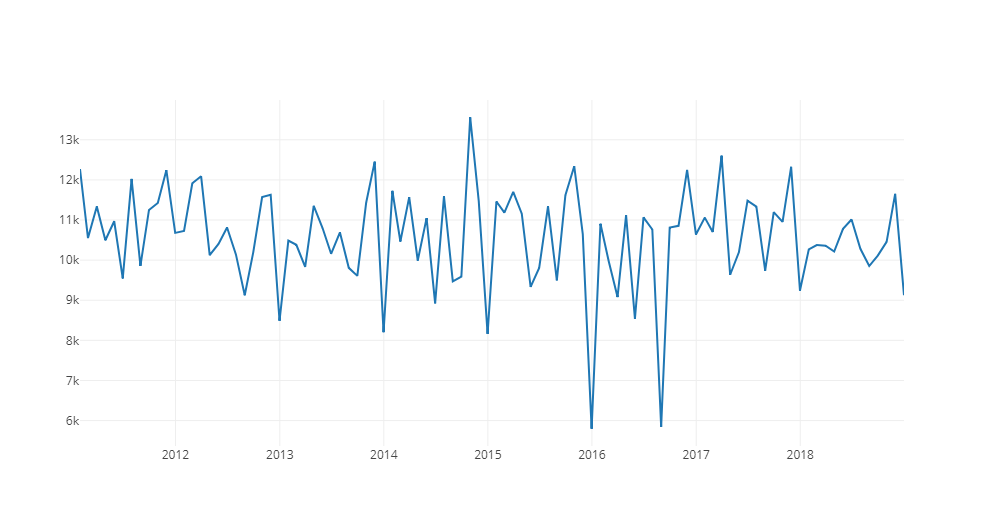

In [3]:
from IPython.display import Image

Image(filename='lehel_overall_guests.png') 

#### The overall number of guests gives us an idea about revenue. And we can see that the number of guests decreases drastically in the ending of every year (December). This can be explained by christmas and end of year holidays.

### Overall guests per year

In [444]:
data = [go.Scatter(
          x=lehel_guests_per_year.index,
          y=lehel_guests_per_year.NbGuests )]
py.iplot(data)

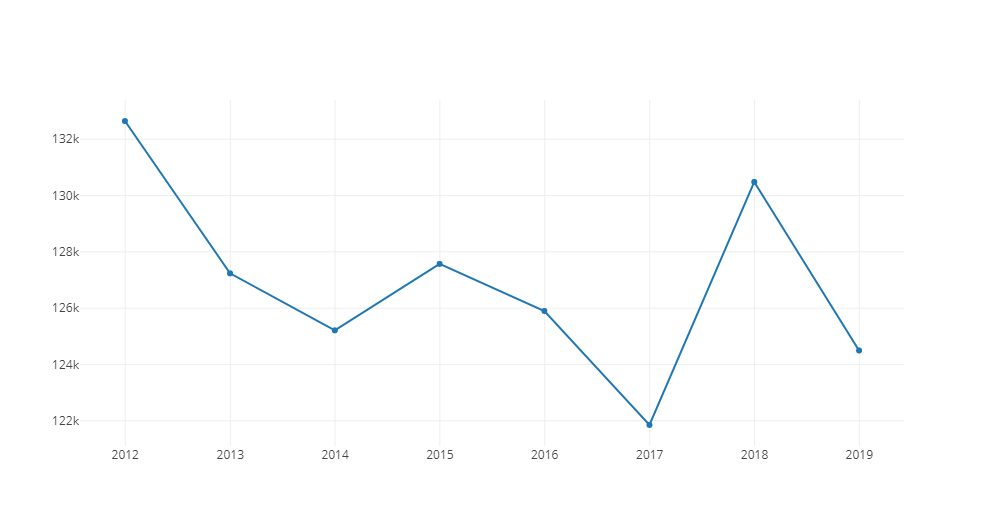

In [4]:
Image(filename='guests_per_year.png') 

#### We can clearly see that 2011 held the most overall number of guests meanwhile in 2016 the number of guests has decreased drastically. But this decrease was compensed during 2017.

In [479]:
lehel_guests.head(10)

,Date,Time,CashPoint,ReceiptNumber
0,2011-03-01,07:29,1,1195883
1,2011-03-01,07:30,1,1195884
3,2011-03-01,07:34,1,1195885
5,2011-03-01,07:34,1,1195886
6,2011-03-01,07:35,1,1195887
8,2011-03-01,07:35,1,1195888
12,2011-03-01,07:37,1,1195889
15,2011-03-01,07:37,1,1195890
17,2011-03-01,07:38,1,1195891
19,2011-03-01,07:40,1,1195892


In [488]:
lehel_guests_weekday=lehel_guests_per_day
lehel_guests_weekday['WeekDay']=lehel_guests_per_day.index.weekday_name

In [489]:
lehel_guests_weekday.head(5)

,NbGuests,WeekDay
Date,,
2011-01-02,657,Sunday
2011-01-03,637,Monday
2011-01-04,485,Tuesday
2011-01-05,0,Wednesday
2011-01-06,573,Thursday


In [490]:
lehel_guests_weekday = lehel_guests_weekday.groupby(['WeekDay']).mean()

In [491]:
lehel_guests_weekday

,NbGuests
WeekDay,
Friday,401.345324
Monday,435.841727
Saturday,124.459135
Sunday,137.117506
Thursday,429.942446
Tuesday,456.160671
Wednesday,450.443645


# Lehel Revenue investigation

#### So we quickly viewed the overall number of guests to get a clear idea about sales and expect some similarities about revenue. 

In [134]:
lehel_items_revenue = pd.read_csv('lehel_items_revenue', engine="python", index_col=0)

In [152]:
lehel_items_revenue.head(10)

,Date,Time,CashPoint,ItemNumber,Amount,ItemDescription,Revenue,NetTotal
0,2011-03-01,07:29,1,511,1,"Backwaren 1,00",1.00,5.54
1,2011-03-01,07:30,1,1211,1,LeberkÃƒÂ¤se Semmel,0.96,4.16
2,2011-03-01,07:30,1,500,1,Semmeln,0.20,4.16
3,2011-03-01,07:34,1,1213,1,LeberkÃƒÂ¤se Teller,2.03,12.61
4,2011-03-01,07:34,1,500,1,Semmeln,0.25,12.61
5,2011-03-01,07:34,1,602,1,"Croissant 0,90",0.85,6.52
6,2011-03-01,07:35,1,600,1,"Butterbreze 1,10",0.85,1.28
7,2011-03-01,07:35,1,612,1,"belegte Backw. 1,40",1.30,1.28
8,2011-03-01,07:35,1,507,1,"Breze 0,65",0.35,10.22
9,2011-03-01,07:35,1,1200,1,Paar Wiener,0.65,10.22


In [136]:
lehel_items_revenue = lehel_items_revenue.reset_index()
lehel_items_revenue = lehel_items_revenue.drop(columns=['index'])

#### Converting Revenue and NetTotal to numeric values

In [137]:
lehel_items_revenue.Revenue = pd.to_numeric(lehel_items_revenue.Revenue.str.replace(',','.'))

In [140]:
lehel_items_revenue.NetTotal = pd.to_numeric(lehel_items_revenue.NetTotal.str.replace(',','.'))

In [142]:
lehel_items_revenue.dtypes

Date                object
Time                object
CashPoint            int64
ItemNumber           int64
Amount               int64
ItemDescription     object
Revenue            float64
NetTotal           float64
dtype: object

In [351]:
lehel_revenue = lehel_items_revenue[['Date','Time','Revenue']]

In [373]:
lehel_revenue.Date[0]

'01-03-2011'

In [377]:
lehel_revenue.to_csv('lehel_rev_date_time.csv')

In [368]:
lehel_revenue.head(5)

,Date,Time,Revenue
0,2011-03-01,07:29,1.00
1,2011-03-01,07:30,0.96
2,2011-03-01,07:30,0.20
3,2011-03-01,07:34,2.03
4,2011-03-01,07:34,0.25


In [328]:
lehel_revenue['Date'] = pd.to_datetime(lehel_revenue['Date'])

In [329]:
lehel_revenue.index = lehel_revenue['Date']

In [330]:
lehel_revenue = lehel_revenue.drop(columns=['Date'])

In [346]:
lehel_revenue.Time = pd.to_datetime(lehel_revenue.Time,format= '%H:%M' ).dt.time

In [367]:
lehel_revenue.Date[0].strftime('%d-%m-%Y')

'01-03-2011'

In [372]:
lehel_revenue.Date=lehel_revenue.Date.apply(lambda x: x.strftime('%d-%m-%Y'))

In [332]:
lehel_revenue['Hour'] = pd.to_numeric(lehel_revenue.Time.str[:2])

In [343]:
lehel_revenue['Min'] = pd.to_numeric(lehel_revenue.Time.str[3:])


In [334]:
lehel_revenue.to_csv("lehel_revenue_hour.csv")

In [170]:
lehel_revenue_per_year = lehel_revenue
lehel_revenue_per_year = lehel_revenue_per_year.resample('Y').sum()

In [172]:
lehel_revenue_per_year

,Revenue
Date,
2011-12-31,344070.24
2012-12-31,352744.83
2013-12-31,353026.85
2014-12-31,376244.10
2015-12-31,371952.84
2016-12-31,368606.86
2017-12-31,402776.83
2018-12-31,396688.16


## Lehel Revenue per year

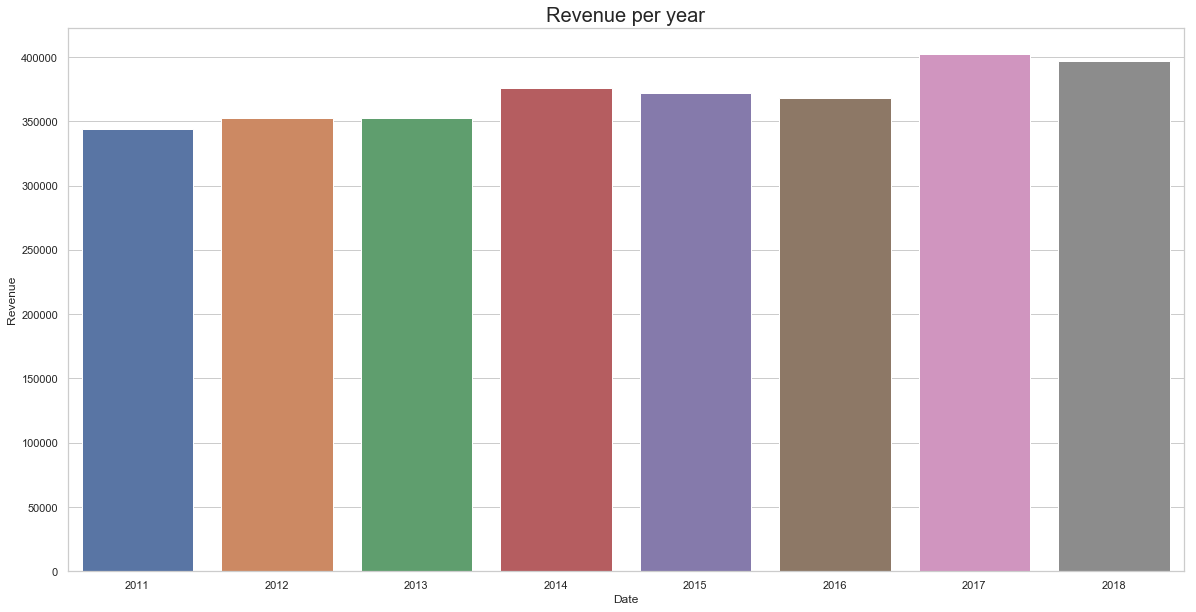

In [200]:
import seaborn as sns

sns.set(style="whitegrid")

plt.subplots(figsize=(20,10))
plt.title('Revenue per year',fontsize=20)
ax = sns.barplot(x=lehel_revenue_per_year.index.year, y="Revenue", data=lehel_revenue_per_year)


#### The annual revenue is slightly fluctuating between 345,000.00 and 400,000.00 Euros.
#### 2011 has unexpectedly the least revenue despite holding the largest number of guests. This can be explained by cheap values of item sold in 2011. Meanwhile 2016 has an average revenue despite having the least number of guests. So in 2016 the average revenue per guest is definitely much higher than the avg. revenue per guest in 2011.

In [202]:
data = [go.Scatter(
          x=lehel_revenue_per_year.index,
          y=lehel_revenue_per_year.Revenue )]
py.iplot(data)

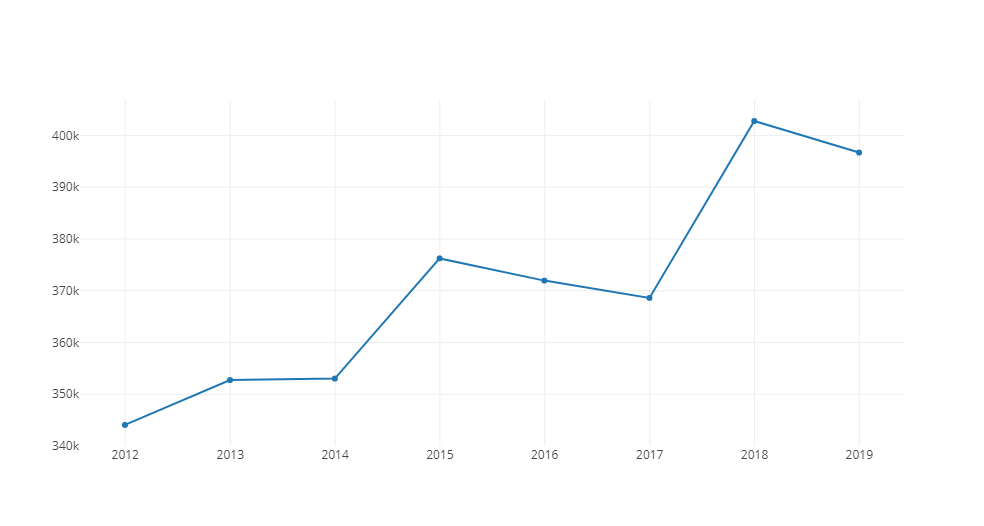

In [217]:
from IPython.display import Image

Image(filename='lehel_revenue_per_year.png') 

#### This plot showcases the difference in annual revenue more than the previous one.

In [203]:
lehel_revenue.head(5)

,Revenue
Date,
2011-03-01,1.00
2011-03-01,0.96
2011-03-01,0.20
2011-03-01,2.03
2011-03-01,0.25


In [209]:
lehel_revenue_per_month = lehel_revenue
lehel_revenue_per_month = lehel_revenue_per_month.resample('M').sum()

In [206]:
lehel_revenue_per_month.head(5)

,Revenue
Date,
2011-01-31,30679.69
2011-02-28,27390.01
2011-03-31,29067.35
2011-04-30,27200.12
2011-05-31,28371.90


In [213]:
data = [go.Scatter(
          x=lehel_revenue_per_month.index,
          y=lehel_revenue_per_month.Revenue )]
py.iplot(data)

### Lehel overall revenue per month

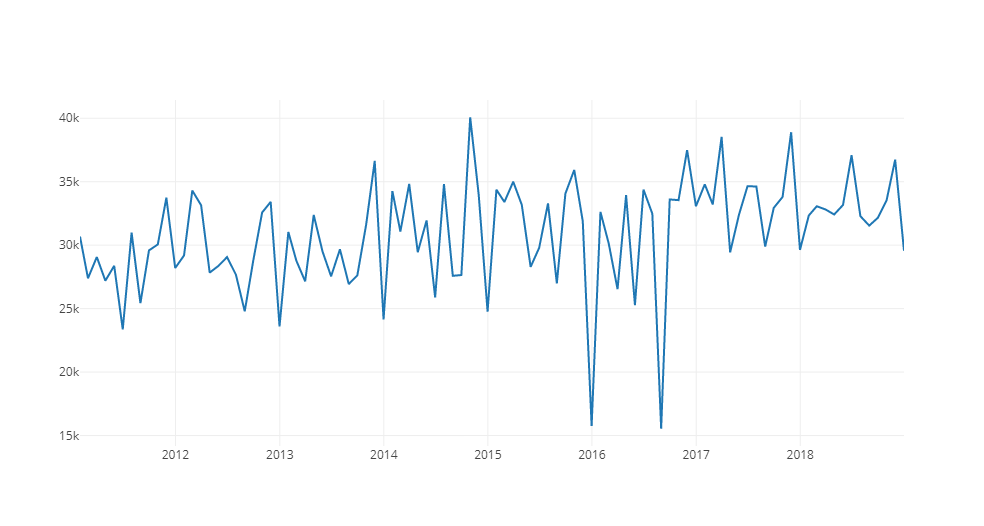

In [216]:
Image(filename='lehel_revenue_per_month.png') 

#### We saw previously saw that December has a decrease of number of guests for each year. This is also the case when visualizing the revenue per month. We can also see that in November of every year there is a peak showing that the revenue in november is always the highest in every year.

In [218]:
lehel_revenue_per_day = lehel_revenue
lehel_revenue_per_day = lehel_revenue_per_day.resample('D').sum()

In [229]:
lehel_revenue_per_day['weekday'] = lehel_revenue_per_day.index.weekday_name

In [237]:
lehel_revenue_per_day_grouped = lehel_revenue_per_day.groupby('weekday').mean()

In [238]:
lehel_revenue_per_day_grouped.head(10)

,Revenue
weekday,
Friday,1140.798106
Monday,1269.942038
Saturday,355.982284
Sunday,396.944460
Thursday,1250.713046
Tuesday,1345.923285
Wednesday,1353.525779


In [240]:
lehel_revenue_per_day_grouped = lehel_revenue_per_day_grouped.reindex(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])

In [241]:
lehel_revenue_per_day_grouped.head(10)

,Revenue
weekday,
Monday,1269.942038
Tuesday,1345.923285
Wednesday,1353.525779
Thursday,1250.713046
Friday,1140.798106
Saturday,355.982284
Sunday,396.944460


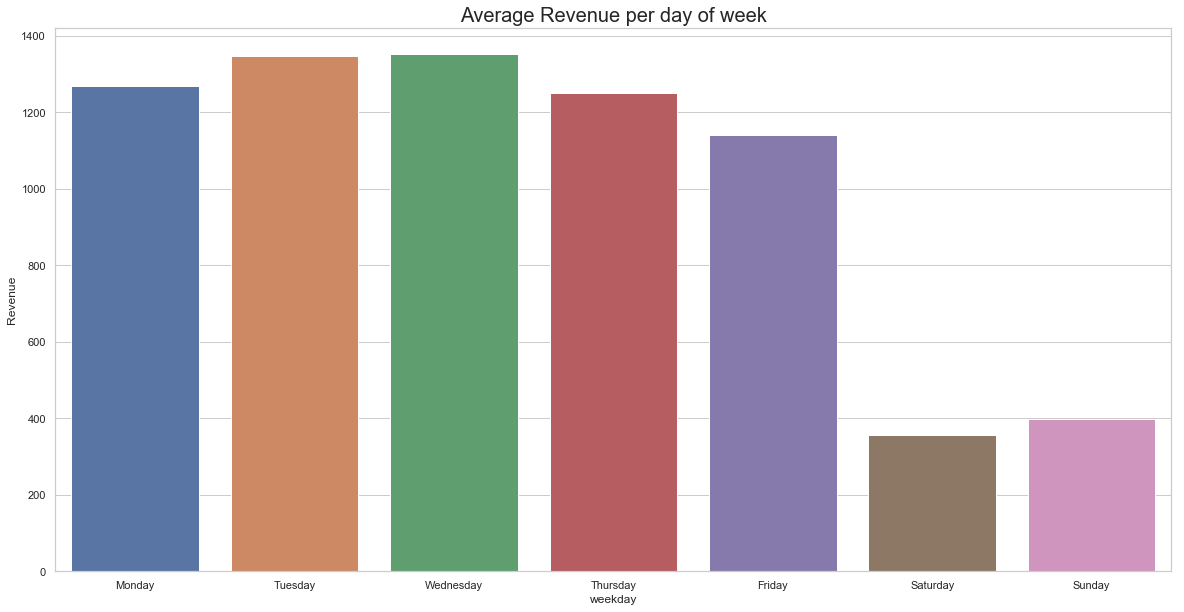

In [245]:
sns.set(style="whitegrid")

plt.subplots(figsize=(20,10))
plt.title('Average Revenue per day of week',fontsize=20)
ax = sns.barplot(x=lehel_revenue_per_day_grouped.index, y="Revenue", data=lehel_revenue_per_day_grouped)

In [243]:
data = [go.Scatter(
          x=lehel_revenue_per_day_grouped.index,
          y=lehel_revenue_per_day_grouped.Revenue )]
py.iplot(data)

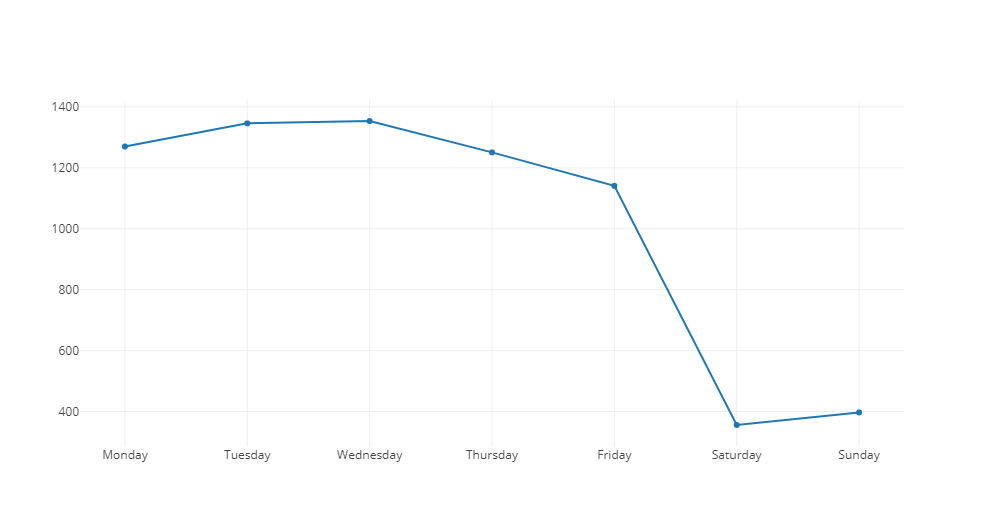

In [244]:
Image(filename='lehel_revenue_per_day_grouped.png') 

#### The two plots above show the average revenue grouped by the day of week. These plots showcase a drastic decrease of revenue during the week-ends. This totally expected since in Saturday and sunday there is not so much people working and if so, they tend to work only in the morning and find themselves not obliged to have lunch in the cantine. 

In [404]:
lehel_revenue_hour = pd.read_csv('lehel_revenue_hour.csv', engine="python", index_col=0)

In [338]:
lehel_revenue_hour_grouped = lehel_revenue_hour.groupby('Hour').mean()

In [339]:
lehel_revenue_hour_grouped.head(5)

,Revenue
Hour,
6,1.433488
7,0.767080
8,0.755930
9,0.784050
10,1.748077


In [379]:
lehel_rev_date_time=pd.read_csv('lehel_rev_date_time.csv',engine="python",index_col=0)

In [387]:
lehel_rev_date_time.head(5)

,Date,Revenue
0,2011-01-03 07:29:00,1.00
1,2011-01-03 07:30:00,0.96
2,2011-01-03 07:30:00,0.20
3,2011-01-03 07:34:00,2.03
4,2011-01-03 07:34:00,0.25


In [381]:
lehel_rev_date_time.Date = lehel_rev_date_time.Date.str.cat(lehel_rev_date_time.Time, sep = " ")

In [384]:
lehel_rev_date_time = lehel_rev_date_time.drop(columns=['Time'])

In [386]:
lehel_rev_date_time['Date'] = pd.to_datetime(lehel_rev_date_time['Date'])

In [389]:
lehel_rev_hour_resample = lehel_rev_date_time
lehel_rev_hour_resample.index = lehel_rev_hour_resample.Date
lehel_rev_hour_resample = lehel_rev_hour_resample.drop(columns=['Date'])
lehel_rev_hour_resample = lehel_rev_date_time.resample('h').sum()

In [406]:
lehel_rev_hour_resample_group = lehel_rev_hour_resample_group.drop(columns=['hour'])

In [437]:
lehel_rev_hour_resample_group = lehel_rev_hour_resample.groupby(lehel_rev_hour_resample.index.hour).mean()

In [438]:
lehel_rev_hour_resample_group

,Revenue,hour
Date,,
0,0.000000,0
1,0.000000,1
2,0.000000,2
3,0.000000,3
4,0.000000,4
5,0.000000,5
6,0.084554,6
7,64.861776,7
8,51.272893,8


In [439]:
lehel.loc[pd.to_numeric(lehel.Time.str[:2])>16]

,Date,Time,CashPoint,ReceiptNumber,Cashier,PaymentType,CardID,Firm,Department,CostUnit,...,Taxes,Amount,Revenue,ItemDescription,NetTotal,StandardPrice,KeyCardCounter,Weight,CurrencyFlag,ValidityCard
15244695,20.01.2016,17:03,2,1031279,3,K/C,20393,11,0,NaN,...,"19,00",1,"0,30","Tagessuppe a 0,30","0,91","0,30",666,0,1,NaN
15244696,20.01.2016,17:03,2,1031280,3,K/C,20393,11,0,NaN,...,"19,00",-1,"-0,30","Tagessuppe a 0,30","1,21","-0,30",667,0,1,NaN


Text(0,0.5,'Revenue')

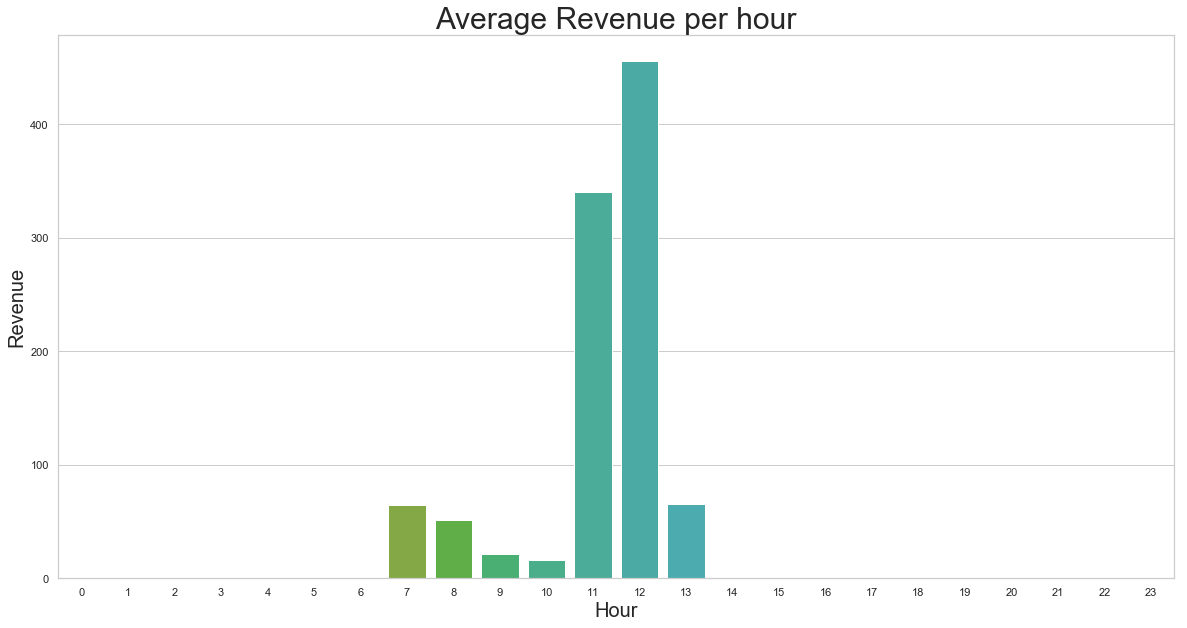

In [440]:
sns.set(style="whitegrid")

plt.subplots(figsize=(20,10))
plt.title('Average Revenue per hour',fontsize=30)
ax = sns.barplot(x=lehel_rev_hour_resample_group.index, y="Revenue", data=lehel_rev_hour_resample_group)
plt.xlabel('Hour',fontsize=20)
plt.ylabel('Revenue',fontsize=20)

In [441]:
data = [go.Scatter(
          x=lehel_rev_hour_resample_group.index,
          y=lehel_rev_hour_resample_group.Revenue )]
py.iplot(data)

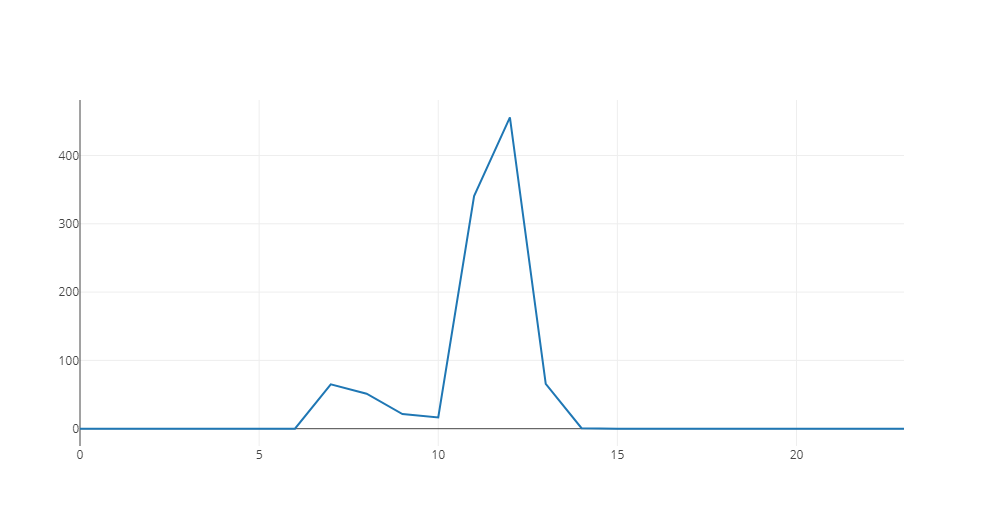

In [442]:
Image(filename='lehel_rev_hour_resample_group.png') 

#### The plots above showcase the average revenue per hour grouped by day.
#### There is clearly two peaks: a little one at 7:00AM~8:00AM and a great one at 11:00AM~12:00PM . We can easily guess that the first peak is explained by morning coffees (breakfast) and the great peak is explained by lunch time. The second peak is much greater than the first because lunch cost is obviously higher than breakfast cost. 
#### we can see the period of day in which the cantine is open is from 6AM to 16PM (shown by the interactive plotly plots) while the active period is from 7AM to 14PM.

## Items investigation

In [7]:
lehel_items = lehel_items_revenue.drop(columns=['CashPoint','Revenue','NetTotal'])

In [8]:
lehel_items_Amount = lehel_items.groupby(lehel_items.ItemNumber).sum()

In [109]:
lehel_items_Amount.head(5)

,Amount
ItemNumber,
102,49553
103,90024
104,23418
111,139
112,32


In [91]:
lehel_items_Amount.loc[lehel_items_Amount.index.duplicated]

,Amount
ItemNumber,


In [100]:
lehel_items_desc = lehel_items_revenue[['ItemNumber','ItemDescription']]

In [101]:
lehel_items_desc.shape

(2011434, 2)

In [102]:
lehel_items_desc.head(5)

,ItemNumber,ItemDescription
0,511,"Backwaren 1,00"
1,1211,LeberkÃƒÂ¤se Semmel
2,500,Semmeln
3,1213,LeberkÃƒÂ¤se Teller
4,500,Semmeln


In [103]:
lehel_items_desc.index = lehel_items_desc.ItemNumber
lehel_items_desc = lehel_items_desc.drop(columns=['ItemNumber'])

In [98]:
lehel_items_desc = lehel_items_desc.drop_duplicates(keep='first')

In [87]:
lehel_items_desc.loc[lehel_items_desc.duplicated()]

,ItemDescription
ItemNumber,


In [37]:
lehel_items_desc = lehel_items_desc.reset_index()
lehel_items_desc = lehel_items_desc.drop(columns=['index'])

In [50]:
lehel_items_desc = lehel_items_desc.sort_index(ascending=True)

In [113]:
lehel_items_desc.tail(5)

,ItemDescription
ItemNumber,
1215,BeiwerkTeller
409,"Dessert a 0,60"
809,O-Saft frisch
409,"Dessert a 0,60"
465,"Gelb 4,20"


In [133]:
lehel_items_revenue = pd.read_csv('lehel_items_revenue', engine="python", index_col=0)

In [134]:
lehel_items_revenue.head(5)

,Date,Time,CashPoint,ItemNumber,Amount,ItemDescription,Revenue,NetTotal
0,2011-03-01,07:29,1,511,1,"Backwaren 1,00","1,00","5,54"
1,2011-03-01,07:30,1,1211,1,LeberkÃƒÂ¤se Semmel,"0,96","4,16"
2,2011-03-01,07:30,1,500,1,Semmeln,"0,20","4,16"
3,2011-03-01,07:34,1,1213,1,LeberkÃƒÂ¤se Teller,"2,03","12,61"
4,2011-03-01,07:34,1,500,1,Semmeln,"0,25","12,61"


In [135]:
lehel_items_revenue.Date = lehel_items_revenue.Date.str.cat(lehel_items_revenue.Time, sep = " ")

In [136]:
lehel_items_revenue = lehel_items_revenue.drop(columns=['Time'])

In [137]:
lehel_items_revenue.index = lehel_items_revenue.Date

In [138]:
lehel_items_revenue.index = pd.to_datetime(lehel_items_revenue.index)

In [131]:
lehel_items_revenue = lehel_items_revenue.resample('h').agg({'Amount':'sum','z':'last'})

In [139]:
top_items = lehel_items_revenue.groupby(['ItemDescription'], as_index=False)['Amount'].sum()

In [143]:
top_items = top_items.sort_values(by=['Amount'],ascending=False)

In [144]:
top_10_items = top_items.head(10)

In [145]:
top_10_items

,ItemDescription,Amount
88,"Beilage a 0,45",158340
94,"Breze 0,65",116544
252,O-Saft frisch,104017
312,"Tagessuppe a 0,30",90024
303,SalatTeller,78852
300,"Salat Port. 0,60",74036
301,Salat Schale,64713
93,BeiwerkTeller,55572
313,"Tagessuppe a 0,80",49553
101,"Dessert a 0,60",48324


Text(0,0.5,'Units')

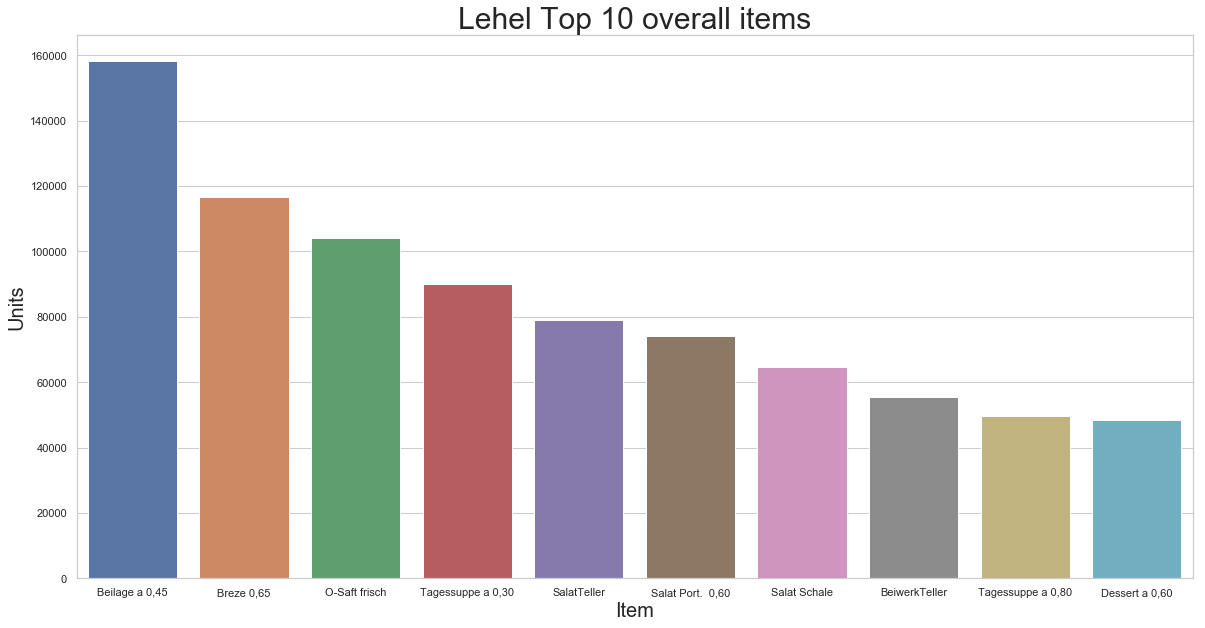

In [153]:
sns.set(style="whitegrid")

plt.subplots(figsize=(20,10))
plt.title('Lehel Top 10 overall items',fontsize=30)
ax = sns.barplot(x=top_10_items.ItemDescription, y=top_10_items.Amount, data=top_10_items)
plt.xlabel('Item',fontsize=20)
plt.ylabel('Units',fontsize=20)

#### It is that Beilage (supplement) is the most sold unit since it can be taken with every kind of other units. Otherwise Salads and soups are invading the top 10 items.